In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical 

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)
number_classes = len(set(y_train))

(60000, 28, 28)
(10000, 28, 28)


In [3]:
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y_train = encoder.transform(y_train)
encoded_Y_test = encoder.transform(y_test)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = to_categorical(encoded_Y_train)
dummy_y_test = to_categorical(encoded_Y_test)

In [4]:
latent_dim = 128 

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([
          layers.Flatten(),
          layers.Dense(latent_dim, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
          layers.Dense(784, activation='sigmoid'),
          layers.Reshape((28, 28))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(latent_dim)

In [5]:
class Autoencoder_adapted(Model):
    def __init__(self, latent_dim):
        super(Autoencoder_adapted, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(latent_dim, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
          layers.Dense(784, activation='sigmoid'),
          layers.Reshape((28, 28))
        ])
        self.cla =tf.keras.Sequential([
            layers.Dense(int(latent_dim/2), activation='relu'),
            layers.Dense(int(latent_dim/4), activation='relu'),
            layers.Dense(number_classes, activation='softmax')
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        label_pred = self.cla(encoded)
        return {"decoded": decoded,
                "label_pred": label_pred}
    
autoencoder_2 = Autoencoder_adapted(latent_dim)

In [6]:
autoencoder.compile(optimizer='adam',
                    loss=losses.MeanSquaredError(),
                    metrics=['accuracy'])

In [7]:
autoencoder.fit(x_train, x_train,
                epochs=100,
                shuffle=True)#,
                #validation_data=(x_test, x_test))

Epoch 1/100
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0346 - accuracy: 0.1058
Epoch 2/100
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0094 - accuracy: 0.2081
Epoch 3/100
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0074 - accuracy: 0.2519
Epoch 4/100
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0066 - accuracy: 0.2729
Epoch 5/100
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0062 - accuracy: 0.2838
Epoch 6/100
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0060 - accuracy: 0.2901: 0s - loss: 0.0060 - accura
Epoch 7/100
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0058 - accuracy: 0.2970
Epoch 8/100
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0057 - accuracy: 0.2985
Epoch 9/100
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0057 - accuracy: 0.3008
Epoch 10/100
1875/1875 [====================

In [8]:
cla_losses = {
	"decoded": "mean_squared_error",
	"label_pred": "categorical_crossentropy",
}

cla_lossWeights = {"decoded": 10.0, "label_pred": 2.0}

autoencoder_2.compile(optimizer='adam', 
                      loss=cla_losses, 
                      loss_weights=cla_lossWeights,
                      metrics=['accuracy'])

In [9]:
history = autoencoder_2.fit(x=x_train,
	y={"decoded": x_train, "label_pred": dummy_y_train},
	epochs=100,
    shuffle=True,
	verbose=1)

Epoch 1/100
1875/1875 [==============================] - 9s 4ms/step - loss: 1.7664 - decoded_loss: 0.0425 - label_pred_loss: 0.6707 - decoded_accuracy: 0.0908 - label_pred_accuracy: 0.7644
Epoch 2/100
1875/1875 [==============================] - 8s 4ms/step - loss: 0.9224 - decoded_loss: 0.0180 - label_pred_loss: 0.3714 - decoded_accuracy: 0.1367 - label_pred_accuracy: 0.8631
Epoch 3/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.8052 - decoded_loss: 0.0154 - label_pred_loss: 0.3257 - decoded_accuracy: 0.1517 - label_pred_accuracy: 0.8801
Epoch 4/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.7522 - decoded_loss: 0.0143 - label_pred_loss: 0.3047 - decoded_accuracy: 0.1618 - label_pred_accuracy: 0.8863
Epoch 5/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.6925 - decoded_loss: 0.0136 - label_pred_loss: 0.2781 - decoded_accuracy: 0.1680 - label_pred_accuracy: 0.8949
Epoch 6/100
1875/1875 [===========================

In [10]:
autoencoder_2.summary()

Model: "autoencoder_adapted"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (32, 128)                 100480    
_________________________________________________________________
sequential_3 (Sequential)    (32, 28, 28)              101136    
_________________________________________________________________
sequential_4 (Sequential)    (32, 10)                  10666     
Total params: 212,282
Trainable params: 212,282
Non-trainable params: 0
_________________________________________________________________


In [11]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

encoded_imgs_2 = autoencoder_2.encoder(x_test).numpy()
decoded_imgs_2 = autoencoder_2.decoder(encoded_imgs_2).numpy()
predicted_labels = autoencoder_2.cla(encoded_imgs_2)

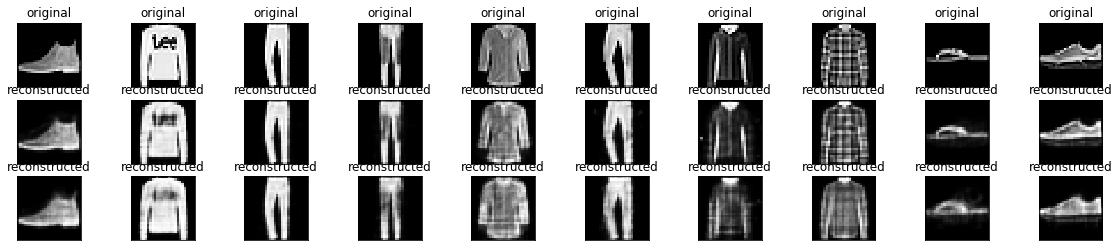

In [12]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display with classification reconstruction
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs_2[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [13]:
from sklearn.metrics import confusion_matrix

In [14]:
y_pred = np.argmax(predicted_labels.numpy(), axis=1)

In [15]:
cm = confusion_matrix(y_test, y_pred)

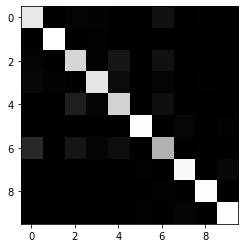

In [16]:
plt.imshow(cm)

In [17]:
cm

array([[887,   0,  18,  14,   5,   2,  68,   0,   6,   0],
       [  4, 976,   1,  10,   4,   0,   4,   0,   1,   0],
       [ 19,   3, 817,   8,  84,   0,  67,   0,   2,   0],
       [ 34,  15,   6, 876,  45,   1,  19,   0,   4,   0],
       [  2,   0, 116,  22, 801,   0,  58,   0,   1,   0],
       [  0,   0,   1,   0,   0, 965,   0,  23,   0,  11],
       [157,   2,  81,  22,  55,   0, 676,   0,   7,   0],
       [  0,   0,   0,   0,   0,  11,   0, 954,   1,  34],
       [  7,   0,   2,   6,   3,   4,   9,   4, 965,   0],
       [  1,   0,   0,   0,   0,  10,   0,  20,   0, 969]], dtype=int64)

In [18]:
print(history.history.keys())

dict_keys(['loss', 'decoded_loss', 'label_pred_loss', 'decoded_accuracy', 'label_pred_accuracy'])


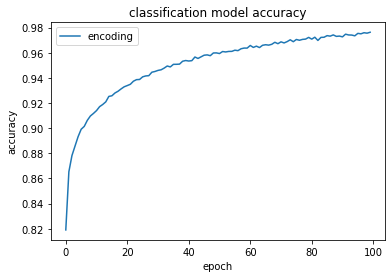

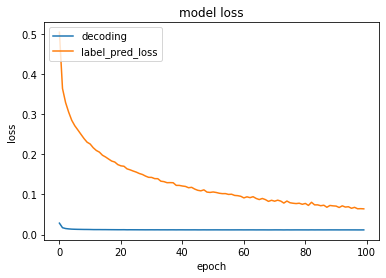

In [19]:
# summarize history for accuracy
plt.plot(history.history['label_pred_accuracy'])
plt.title('classification model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['encoding', 'classification'], loc='upper left')
plt.show()
# summarize history for loss
# plt.plot(history.history['loss'])
plt.plot(history.history['decoded_loss'])
plt.plot(history.history['label_pred_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['decoding', 'label_pred_loss'], loc='upper left')
plt.show()

In [20]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
intermediates_tsne = tsne.fit_transform(encoded_imgs_2)

In [21]:
tsne = TSNE(n_components=2, random_state=0)
intermediates_tsne_without = tsne.fit_transform(encoded_imgs)

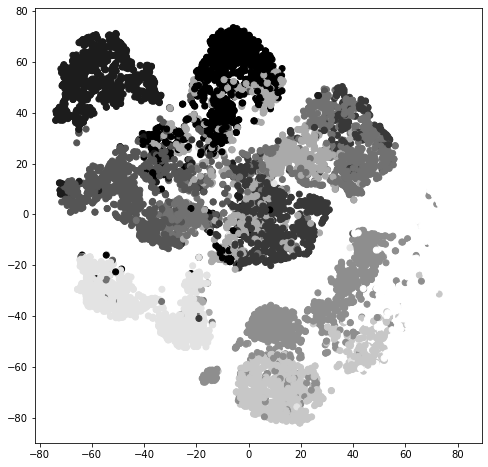

In [155]:
plt.figure(figsize=(8, 8))
plt.scatter(x = intermediates_tsne[:,0], y=intermediates_tsne[:,1], c=y_pred)
plt.show()

In [22]:
seperators = np.random.randint(10, 100, 10)
def seperate_colors(colors):
    return [color + seperators[color] for color in colors]

sc_colors = seperate_colors(y_test)
y_test.shape
# print(pred_colors)

(10000,)

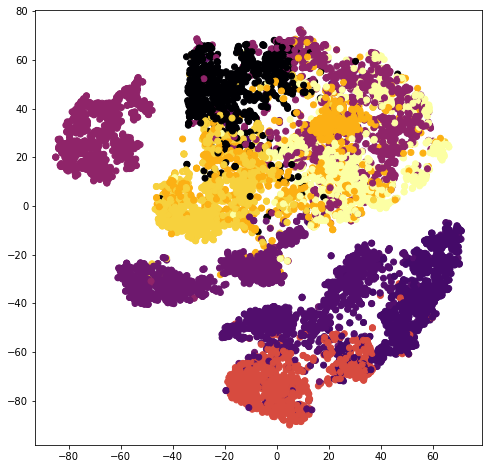

In [23]:
plt.figure(figsize=(8, 8))
plt.scatter(x = intermediates_tsne[:,0], y=intermediates_tsne[:,1], c=sc_colors, cmap='inferno')
plt.show()

No handles with labels found to put in legend.


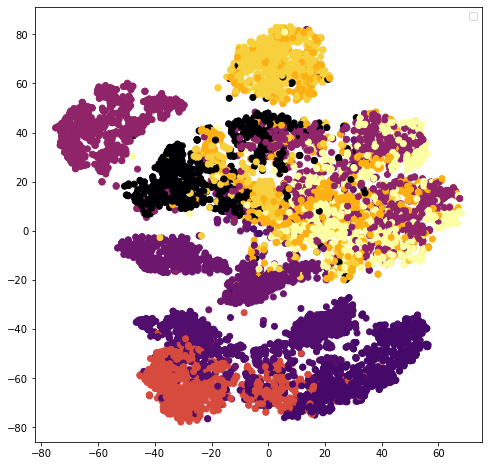

In [24]:
plt.figure(figsize=(8, 8))
plt.scatter(x = intermediates_tsne_without[:,0], y=intermediates_tsne_without[:,1], c=sc_colors, cmap='inferno')
plt.legend()
plt.show()

In [25]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

In [26]:
pca = PCA(n_components=2)
without = normalize(encoded_imgs, axis=1, norm='l1')
without = pca.fit_transform(without)
with_cla = normalize(encoded_imgs_2, axis=1, norm='l1')
with_cla = pca.fit_transform(with_cla)

No handles with labels found to put in legend.


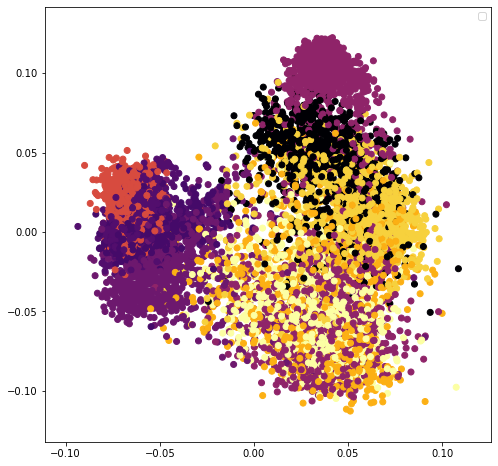

In [27]:
plt.figure(figsize=(8, 8))
plt.scatter(x = with_cla[:,0], y=with_cla[:,1], c=sc_colors, cmap='inferno')
plt.legend()
plt.show()

No handles with labels found to put in legend.


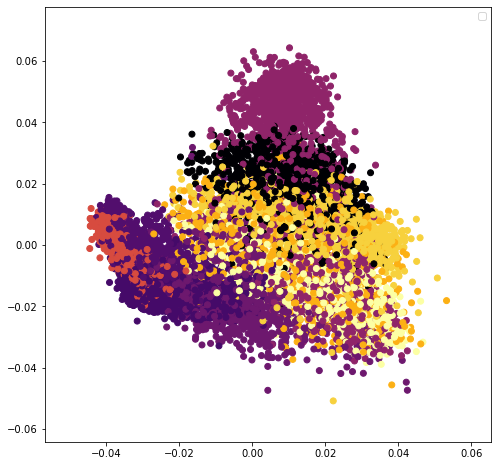

In [28]:
plt.figure(figsize=(8, 8))
plt.scatter(x = without[:,0], y=without[:,1], c=sc_colors, cmap='inferno')
plt.legend()
plt.show()